# Precision confidence interval in the presence of unreliable labels

Consider a binary classifier that produced the following counts of true positives (TP) and false positives (FP) on test data.

In [3]:
tp_observed = 5285
fp_observed = 3184

We would like to know the 95% confidence interval for precision metric of this classifier. [Goutte and Gaussier](https://pdfs.semanticscholar.org/e399/9a46cb8aaf71131a77670da5c5c113aad01d.pdf) showed that precision follows the Beta distribution with the counts of TPs and FPs as parameters, adjusted for prior. We will use uniform prior, $Beta(1,1)$.

In [4]:
import pymc3 as pm

with pm.Model() as model:
    precision_reliable = pm.Beta('precision_reliable', tp_observed + 1, fp_observed + 1)

The distribution and 95% confidence interval can be plotted by sampling this variable.

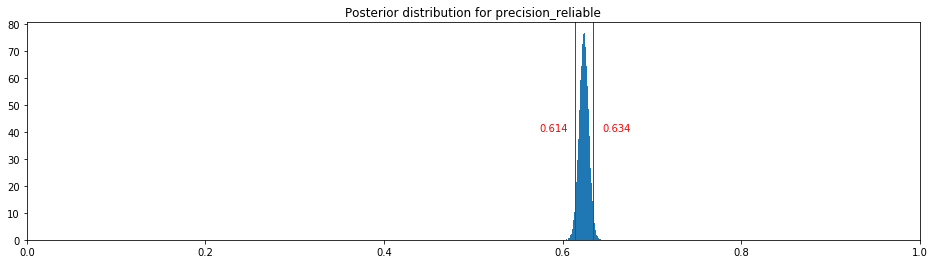

In [5]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import numpy as np

def plot_dist(variable, confidence_level_percent=95):
    figsize(16, 4)
    samples = variable.random(size=100000)
    _, ax = plt.subplots()
    plt.hist(samples, bins=100, normed=True, histtype="stepfilled")
    plt.title("Posterior distribution for %s" % variable.name)
    plt.xlim(0, 1)
    conf_interval_min = np.percentile(samples, (100-confidence_level_percent) / 2)
    conf_interval_max = np.percentile(samples, confidence_level_percent  +  (100-confidence_level_percent) / 2)
    ax.axvline(x=conf_interval_min, ymin=0, ymax=1, color='r', linewidth=1)
    ax.text(x=conf_interval_min-0.04, y=ax.get_ylim()[1]/2, s=round(conf_interval_min, 3), color='r')
    ax.axvline(x=conf_interval_max, ymin=0, ymax=1, color='r', linewidth=1)
    ax.text(x=conf_interval_max+0.01, y=ax.get_ylim()[1]/2, s=round(conf_interval_max, 3), color='r')
    
    
plot_dist(precision_reliable)

We suspected the labels used to identify positives and negatives in the test set were inaccurate, so we reviewed randomly selected observed TPs and FPs, 100 from each group, and counted how many of them had incorrect labels.

In [6]:
reviewed_tp = 100
mislabelled_tp = 7
reviewed_fp = 100
mislabelled_fp = 31

How can we account for the mislabelling when calculating the posterior of precision? 

One way would be to consider the true mislabelling rates to follow a certain probability distribution, and caculate the posterior based on the available evidence. Beta distribution again looks like a good candidate, seeing that it can be used to describe the probability of success -- "success" meaning a given example being mislabelled, in our case. Again, we will assume uninformative prior, i.e. $Beta(1,1)$.

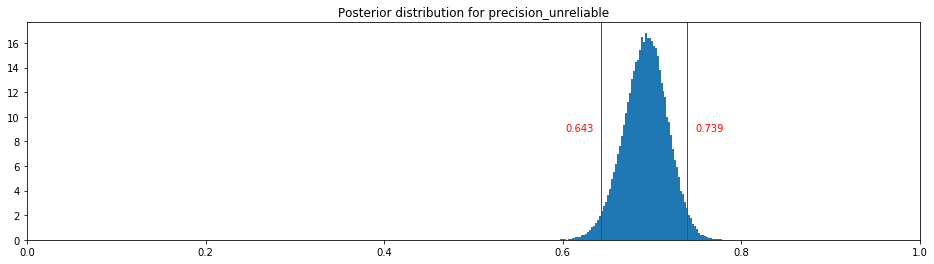

In [9]:
def precision_with_unreliable_labels(prior_tp=(1,1), prior_fp=(1,1)):
    with pm.Model() as model:
        mislabel_rate_tp = pm.Beta('mislabel_rate_tp', mislabelled_tp + prior_tp[0],
                                                       reviewed_tp - mislabelled_tp + prior_tp[1])
        mislabel_rate_fp = pm.Beta('mislabel_rate_fp', mislabelled_fp + prior_fp[0],
                                                       reviewed_fp - mislabelled_fp + prior_fp[1])
        tp_actual = tp_observed * (1-mislabel_rate_tp) + fp_observed * mislabel_rate_fp
        fp_actual = fp_observed * (1-mislabel_rate_fp) + tp_observed * mislabel_rate_tp
        return pm.Beta('precision_unreliable', tp_actual + 1, fp_actual + 1)

plot_dist(precision_with_unreliable_labels())

Instead of just scaling the observed numbers of TPs and FPs using the stochastic mislabelling rate, we can consider the process of identifying _actual_ TPs and FPs as a series of Bernoulli trials, with the success rates determined by the mislabelling rates, and the number of trials equal to our observations. We have to take care to appropriately model the dependency between the numbers of TPs labelled correctly and wrongly.

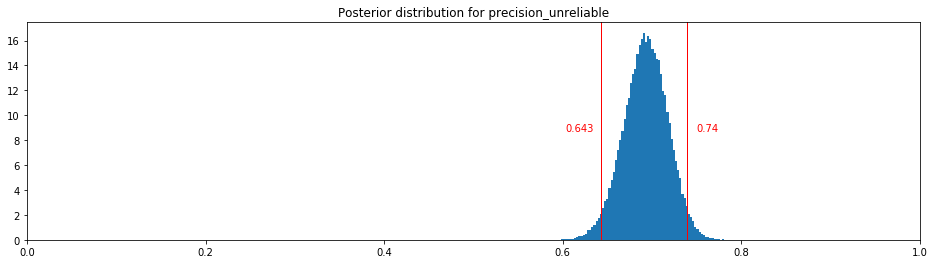

In [10]:
def precision_with_unreliable_labels(prior_tp=(1,1), prior_fp=(1,1)):
    with pm.Model() as model:
        mislabel_rate_tp = pm.Beta('mislabel_rate_tp', mislabelled_tp + prior_tp[0],
                                                       reviewed_tp - mislabelled_tp + prior_tp[1])
        mislabel_rate_fp = pm.Beta('mislabel_rate_fp', mislabelled_fp + prior_fp[0],
                                                       reviewed_fp - mislabelled_fp + prior_fp[1])
        tp_labelled_wrongly = pm.Binomial('tp_mislabelled', tp_observed, mislabel_rate_tp)
        tp_labelled_correctly = tp_observed - tp_labelled_wrongly
        fp_labelled_wrongly = pm.Binomial('fp_mislabelled', fp_observed, mislabel_rate_fp)
        fp_labelled_correctly = fp_observed - fp_labelled_wrongly
        tp_actual = tp_labelled_correctly + fp_labelled_wrongly
        fp_actual = fp_labelled_correctly + tp_labelled_wrongly
        return pm.Beta('precision_unreliable', tp_actual + 1, fp_actual + 1)

plot_dist(precision_with_unreliable_labels())

It turns out that this more elaborate modelling does not change the result.

In reality we probably have some prior expectation regarding the mislabelling rates. For example, we might believe it likely that less than half of the examples is mislabelled, or that positives are more likely to be incorrectly labelled as negatives than vice versa. Those beliefs can be encoded by the priors used for mislabelling rates.

Say, before reviewing the samples we were very certain the proportion of mislabelled FPs is small, but we were not so sure about the TPs. This can be modelled as appropriate shape parameters for the prior Beta distributions.

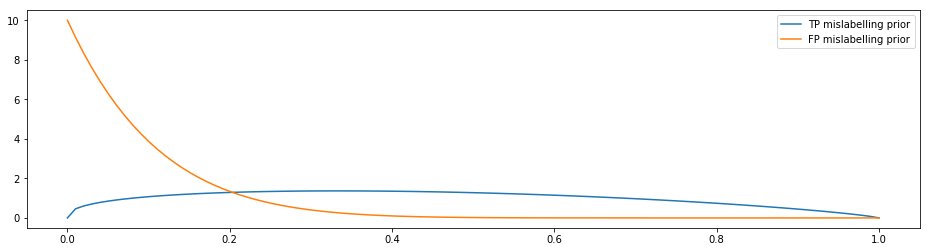

In [11]:
import scipy.stats

prior_tp = (1.4, 1.8)
prior_fp = (1, 10)

x = np.linspace(0, 1.0, 100)
plt.plot(x, scipy.stats.beta.pdf(x, *prior_tp), label="TP mislabelling prior")
plt.plot(x, scipy.stats.beta.pdf(x, *prior_fp), label="FP mislabelling prior")
plt.legend()
plt.show()

How does it affect the precision confidence interval?

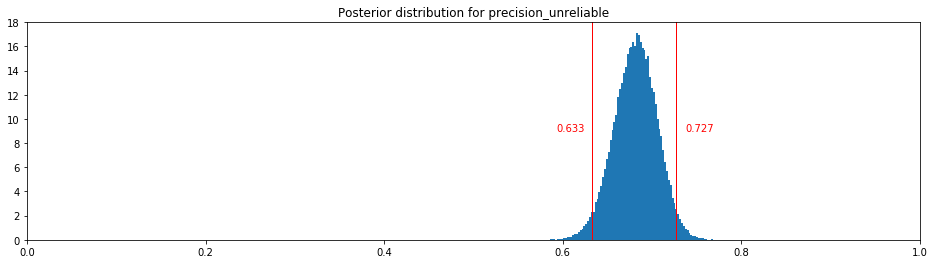

In [12]:
plot_dist(precision_with_unreliable_labels(prior_tp, prior_fp))